# Intro to COBRA

## References

- Palsson, B. Ø. (2015). Systems Biology: Constraint-based Reconstruction and Analysis. Cambridge: Cambridge University Press. DOI: 10.1017/CBO9781139854610
  - [Video lectures](https://systemsbiology.ucsd.edu/Publications/Books/SB1-2LectureSlides)
- [openCOBRA](https://opencobra.github.io/)
- [Latest COBRApy documentation](https://cobrapy.readthedocs.io/en/latest/)
- Another tutorial: https://github.com/migp11/cobrapy-tutorial

## Building a tiny network

In [29]:
import cobra
from cobra.core import Model
from cobra.core import Reaction
from cobra.core import Metabolite
from cobra.core import Gene

from plotnet import NetPlotter  # this is a custom class to ease visualization
import pandas as pd             # a library to handle dataframes (tables)

Here we implement the network proposed by [Kauffman et al. (2003)](https://doi.org/10.1016/j.copbio.2003.08.001) in Figure 1a:

![](https://ars.els-cdn.com/content/image/1-s2.0-S0958166903001174-gr1.jpg)

First, we initialize the model with an ID (here, "tiny", because it's tiny).
We also add a description of the model.

In [2]:
model = Model("tiny")
model.description = "I'm tiny!"

print(f"Hello model '{model.id}'!")

Hello model 'tiny'!


COBRA models are defined primarily by their stoichiometric matrix (also known as $S$)
and reaction lower and upper bounds. These convey the directionality of reactions, and
are defined by thermodynamics.

To define the stoichiometric matrix, we first define the metabolites that participate
in the reaction (`A`, `B` and `C`). Then we can add each internal reaction (`v1` to `v4`).
With COBRApy, we can define their bounds at the same time. Bounds (0, 1000) mean that reactions
can occur only in the forward direction (consumption of reagents), but they also can be inactive (with flux=0).
Here, 1000 is an arbitrary number that means an unconstrained or "infinite" possible flux.
To force a minimum flux of, for example, 10, bounds would need to be defined as (10, 1000).
To define a reversible reaction, bounds would need to be defined as (-1000, 1000).

Finally, we add the defined reactions to the model.

In [3]:
a = Metabolite(id="A")
b = Metabolite(id="B")
c = Metabolite(id="C")

v1 = Reaction(id="v1", lower_bound=0, upper_bound=1000)
v1.add_metabolites({a: -1, b: 1})

v2 = Reaction(id="v2", lower_bound=0, upper_bound=1000)
v2.add_metabolites({a: -1, c: 1})

v3 = Reaction(id="v3", lower_bound=0, upper_bound=1000)
v3.add_metabolites({c: -1, a: 1})

v4 = Reaction(id="v4", lower_bound=0, upper_bound=1000)
v4.add_metabolites({c: -1, b: 1})

model.add_reactions([v1, v2, v3, v4])

Similarly, we add the reactions of the system boundary.
These can work as an abstraction of the environment in which the organism lives.

In [4]:
b1 = Reaction(id="b1", lower_bound=0, upper_bound=1000)
b1.add_metabolites({a: 1})

b2 = Reaction(id="b2", lower_bound=0, upper_bound=1000)
b2.add_metabolites({b: -1})

b3 = Reaction(id="b3", lower_bound=0, upper_bound=1000)
b3.add_metabolites({c: -1})

model.add_reactions([b1, b2, b3])

Now, let's visualize the model as a network of metabolites (in orange) and reactions (in blue).
Here we use the `NetPlotter` custom class in `plotnet.py` for convenience, but there are other ways to do it! For example, https://escher.github.io.

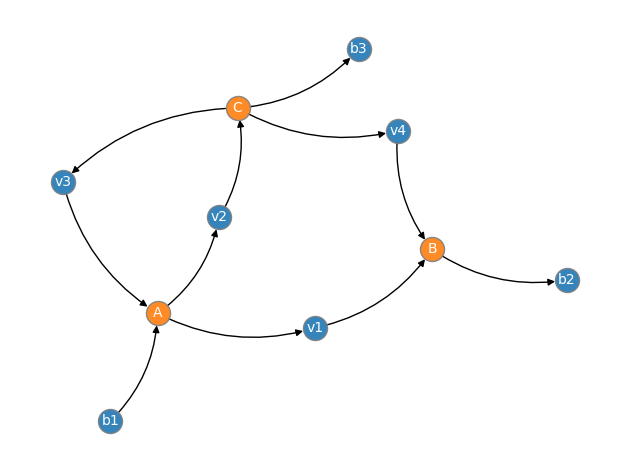

In [5]:
np = NetPlotter(model)
np.plot()

Also, check out the stoichiometrix matrix $S$.
Here, we use the `pandas` library just to label the rows and columns,
to make the visualization prettier.

In [37]:
matrix = cobra.util.array.create_stoichiometric_matrix(model)

pd.DataFrame(
    data=matrix,
    columns=model.reactions.list_attr("id"),
    index=model.metabolites.list_attr("id"))

,v1,v2,v3,v4,b1,b2,b3
A,-1.0,-1.0,1.0,0.0,1.0,0.0,0.0
B,1.0,0.0,0.0,1.0,0.0,-1.0,0.0
C,0.0,1.0,-1.0,-1.0,0.0,0.0,-1.0


## Simulating metabolic fluxes

Flux balance analysis (FBA) is often used to compute
the state of the network by optimizing a metabolic objective.
Common objectives include biomass production, ATP production, etc.
Here we will try several objectives.

First, we try to maximize the flux through reaction `b2`. Its formula is `B -->`.
In a real model, this could be used to represent the synthesis of metabolite `B`.
Thus, if we perform this simulation, we will get the optimal flux distribution
through the sistem that maximizes the production of metabolite `B`.

In COBRApy, setting an objective is easy (see the [documentation](https://cobrapy.readthedocs.io/en/latest/simulating.html) for more info):

In [6]:
model.objective = "b2"
model.objective_direction = "max"

Then, we run FBA and display the optimized flux distribution (i.e. the
fluxes passing through each reaction of the network).

In [7]:
solution = model.optimize()
solution.fluxes

v1    1000.0
v2       0.0
v3       0.0
v4       0.0
b1    1000.0
b2    1000.0
b3       0.0
Name: fluxes, dtype: float64

We can also visualize this flux distribution using `NetPlotter`. Here
arrows highlighted in blue represent active reactions carrying metabolic flux.

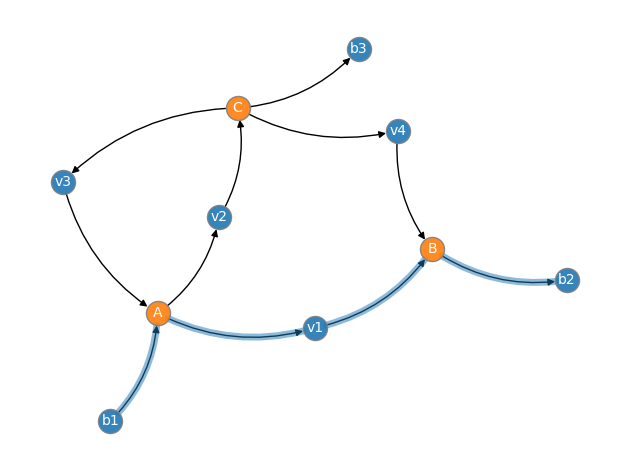

In [8]:
np = NetPlotter(model)
np.plot()

Using the same objective reaction, let's modify the constraints of the network and see how the fluxes change.
For example, we can force a minimum flux of 10 through reaction `b3` (formula: `C -->`), which forces
the "synthesis" of metabolite `C` to some amount (here, 10 flux units).

In [12]:
model.reactions.b3.bounds = (10, 1000)

solution = model.optimize()
solution.fluxes

v1     990.0
v2      10.0
v3       0.0
v4       0.0
b1    1000.0
b2     990.0
b3      10.0
Name: fluxes, dtype: float64

See how the fluxes change compared with the previous optimization!
Here, the input flux through metabolite `A` is split due to the new bound
that forces the activity of reaction `b3`, which forces the production of
metabolite `C`.
Visualize the network to see it more clearly:

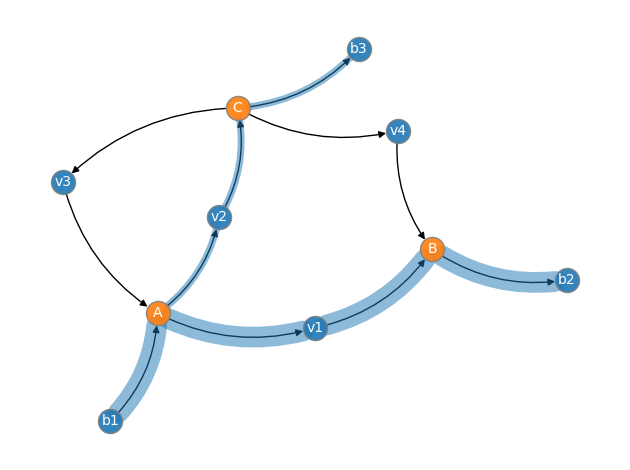

In [10]:
np = NetPlotter(model)
np.plot()

Restore the original bounds of reaction `b3` before continuing.

In [20]:
model.reactions.b3.bounds = (0, 1000)

## Simulating gene KOs

```mermaid
flowchart TB

geneX --> and
geneY --> and
and{AND} --> v1(Reaction v2)

geneZ --> v2(Reaction v2)

geneV --> or
geneW --> or
or{OR} --> v3(Reaction v3)

geneU --> v4(Reaction v4)
```

Luckily for us, with COBRApy we can provide GPR rules as plain text!

In [25]:
model.reactions.v1.gene_reaction_rule = "geneX and geneY"
model.reactions.v2.gene_reaction_rule = "geneZ"
model.reactions.v3.gene_reaction_rule = "geneV or geneW"
model.reactions.v4.gene_reaction_rule = "geneU"

In [22]:
from cobra.flux_analysis import single_gene_deletion, double_gene_deletion

single_gene_deletion(model)

,ids,growth,status
0,{geneX},1000.0,optimal
1,{geneV},1000.0,optimal
2,{geneZ},1000.0,optimal
3,{geneU},1000.0,optimal
4,{geneW},1000.0,optimal
5,{geneY},1000.0,optimal


In [26]:
double_gene_deletion(model)

,ids,growth,status
0,{geneY},1000.0,optimal
1,"{geneZ, geneX}",0.0,optimal
2,"{geneV, geneU}",1000.0,optimal
3,"{geneY, geneZ}",0.0,optimal
4,"{geneW, geneU}",1000.0,optimal
5,{geneX},1000.0,optimal
6,{geneV},1000.0,optimal
7,"{geneV, geneX}",1000.0,optimal
8,"{geneY, geneU}",0.0,optimal
9,"{geneZ, geneV}",1000.0,optimal
